In [49]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing

import tensorflow as tf
from keras import models
from keras import layers

import math
from sklearn.model_selection import train_test_split, StratifiedKFold
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils

from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline
keras.backend.set_image_data_format('channels_last')

# Lendo csv pré-processado

In [50]:
df = pd.read_csv("credit_preprocessed.csv")

df.head()

,ID,LIMIT_BAL,SEX,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,...,PAY_6_D1,PAY_6_D2,PAY_6_D3,PAY_6_D4,PAY_6_D5,PAY_6_D6,PAY_6_D7,PAY_6_D8,PAY_6_D9,Class
0,1,0.010101,0,0.051724,0.149982,0.069164,0.086723,0.160138,0.080648,0.260979,...,0,0,0,0,0,0,0,0,0,1
1,2,0.111111,0,0.086207,0.148892,0.067858,0.087817,0.163220,0.084074,0.263485,...,0,1,0,0,0,0,0,0,0,1
2,3,0.080808,0,0.224138,0.172392,0.079532,0.093789,0.173637,0.095470,0.272928,...,0,0,0,0,0,0,0,0,0,0
3,4,0.040404,0,0.275862,0.188100,0.111995,0.113407,0.186809,0.109363,0.283685,...,0,0,0,0,0,0,0,0,0,0
4,5,0.040404,1,0.620690,0.154144,0.071601,0.106020,0.179863,0.099633,0.275681,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df.shape
df = df.drop('ID', axis=1)

# Aplicando Keras - softmax

In [52]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model

model = models.Sequential()
model.add(layers.Dense(46, activation='relu', input_shape=(2460000,)))
model.add(layers.Dense(46, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))



def load_data_kfold(k):
    
    train = df
    
    X_train = np.array(df.drop('Class', axis=1).values)
    
    y_train = np.array(train["Class"].values)
    
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(X_train, y_train))
    
    return folds, X_train, y_train

k = 7
folds, X_train, y_train = load_data_kfold(k)

def get_model():
    
    model = models.Sequential()
    
    model.add(layers.Dense(46, activation='relu', input_shape=(82,)))
    model.add(layers.Dense(46, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 46)                3818      
_________________________________________________________________
dense_104 (Dense)            (None, 46)                2162      
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 47        
Total params: 6,027
Trainable params: 6,027
Non-trainable params: 0
_________________________________________________________________


In [53]:
import math





test_loss = np.asarray([])
test_accuracy = np.asarray([])
test_sensibilidade = np.asarray([])
test_especificidade = np.asarray([])
test_eficiencia = np.asarray([])
test_valor_preditivo_positivo = np.asarray([])
test_valor_preditivo_negativo = np.asarray([])
test_PHI = np.asarray([])

for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]
    
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    model = get_model()
    model.fit(X_train_cv,
              y_train_cv,
              epochs=2,
              batch_size=32)
    
    t_loss, t_accuracy = model.evaluate(X_valid_cv, y_valid_cv)

    
    y_pred = model.predict(X_valid_cv)
    y_pred = (y_pred>0.5)
    
    cm = confusion_matrix(y_valid_cv, y_pred)
    print("\n")
    print(cm)
    
    VP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    VN = cm[1][1]
    
    test_loss = np.append(test_loss, t_loss)
    test_accuracy = np.append(test_accuracy, t_accuracy)
    test_sensibilidade = np.append(test_sensibilidade, (VP/(VP+FN))*100)
    test_especificidade = np.append(test_especificidade, (VN/(VN+FP))*100)
    test_eficiencia = np.append(test_eficiencia, (((VP/(VP+FN)) + (VN/(VN+FP)))/2)*100)
    test_valor_preditivo_positivo = np.append(test_valor_preditivo_positivo, (VP/(VP+FP))*100)
    test_valor_preditivo_negativo = np.append(test_valor_preditivo_negativo, (VN/(VN+FN))*100)
    test_PHI = np.append(test_PHI, (VP*VN - FP*FN) / math.sqrt((VP + FP)*(VP + FN)*(VN + FP)*(VN + FN)))
    
    if j == 0: fold0 = np.array([test_loss[j], test_accuracy[j], test_eficiencia[j], test_PHI[j], test_sensibilidade[j], test_especificidade[j], test_valor_preditivo_positivo[j], test_valor_preditivo_negativo[j]])
    elif j == 1: fold1 = np.array([test_loss[j], test_accuracy[j], test_eficiencia[j], test_PHI[j], test_sensibilidade[j], test_especificidade[j], test_valor_preditivo_positivo[j], test_valor_preditivo_negativo[j]])
    elif j == 2: fold2 = np.array([test_loss[j], test_accuracy[j], test_eficiencia[j], test_PHI[j], test_sensibilidade[j], test_especificidade[j], test_valor_preditivo_positivo[j], test_valor_preditivo_negativo[j]])
    elif j == 3: fold3 = np.array([test_loss[j], test_accuracy[j], test_eficiencia[j], test_PHI[j], test_sensibilidade[j], test_especificidade[j], test_valor_preditivo_positivo[j], test_valor_preditivo_negativo[j]])
    elif j == 4: fold4 = np.array([test_loss[j], test_accuracy[j], test_eficiencia[j], test_PHI[j], test_sensibilidade[j], test_especificidade[j], test_valor_preditivo_positivo[j], test_valor_preditivo_negativo[j]])
    elif j == 5: fold5 = np.array([test_loss[j], test_accuracy[j], test_eficiencia[j], test_PHI[j], test_sensibilidade[j], test_especificidade[j], test_valor_preditivo_positivo[j], test_valor_preditivo_negativo[j]])
    elif j == 6: fold6 = np.array([test_loss[j], test_accuracy[j], test_eficiencia[j], test_PHI[j], test_sensibilidade[j], test_especificidade[j], test_valor_preditivo_positivo[j], test_valor_preditivo_negativo[j]])

    
    print("\nLoss: %.4s" % (test_loss[j]))
    print("Acurácia: %.5s%%" % (test_accuracy[j]))
    print("Sensibilidade: %.5s%%" % (test_sensibilidade[j]))
    print("Especificidade: %.5s%%" %(test_especificidade[j]))
    print("Eficiencia: %.5s%%" %(test_eficiencia[j]))
    print("Valor Preditivo Positivo: %.5s%%" %(test_valor_preditivo_positivo[j]))
    print("Valor Preditivo Negativo: %.5s%%" %(test_valor_preditivo_negativo[j]))
    print("Coeficiente PHI: %.4s\n" % (test_PHI[j]))

print("Media  |  Variância")
print("\nLoss: %.4s | %.4s" % (test_loss.mean(), test_loss.var()))
print("Acurácia: %.5s%% | %.5s%%" % (test_accuracy.mean(), test_accuracy.var()))
print("Eficiencia: %.5s%% | %.5s%%" %(test_eficiencia.mean(), test_eficiencia.var()))
print("Coeficiente PHI: %.4s | %.4s" % (test_PHI.mean(), test_PHI.var()))
print("Sensibilidade: %.5s%% | %.5s%%" % (test_sensibilidade.mean(), test_sensibilidade.var()))
print("Especificidade: %.5s%% | %.5s%%" %(test_especificidade.mean(), test_especificidade.var()))
print("Valor Preditivo Positivo: %.5s%% | %.5s%%" %(test_valor_preditivo_positivo.mean(), test_valor_preditivo_positivo.var()))
print("Valor Preditivo Negativo: %.5s%% | %.5s%%" %(test_valor_preditivo_negativo.mean(), test_valor_preditivo_negativo.var()))


# totalVariation = np.asarray([test_loss.var(), test_accuracy.var(), test_eficiencia.var(), test_PHI.var(), test_sensibilidade.var(), test_especificidade.var(), test_valor_preditivo_positivo.var(), test_valor_preditivo_negativo.var()])



Fold  0
Epoch 1/2
25714/25714 [==============================] - 4s 170us/step - loss: 0.4528 - acc: 0.8121
Epoch 2/2
4286/4286 [==============================] - 1s 125us/step


[[3161  177]
 [ 608  340]]

Loss: 0.43
Acurácia: 0.816%
Sensibilidade: 83.86%
Especificidade: 65.76%
Eficiencia: 74.81%
Valor Preditivo Positivo: 94.69%
Valor Preditivo Negativo: 35.86%
Coeficiente PHI: 0.38


Fold  1
Epoch 1/2
25714/25714 [==============================] - 3s 122us/step - loss: 0.4562 - acc: 0.8114
Epoch 2/2
4286/4286 [==============================] - 1s 140us/step


[[3207  131]
 [ 637  311]]

Loss: 0.43
Acurácia: 0.820%
Sensibilidade: 83.42%
Especificidade: 70.36%
Eficiencia: 76.89%
Valor Preditivo Positivo: 96.07%
Valor Preditivo Negativo: 32.80%
Coeficiente PHI: 0.39


Fold  2
Epoch 1/2
25714/25714 [==============================] - 3s 113us/step - loss: 0.4511 - acc: 0.8116
Epoch 2/2
4286/4286 [==============================] - 1s 135us/step


[[3177  161]
 [ 616  332]]

Loss: 0.44
Acu

In [54]:
print(fold0)

[ 0.43444398  0.81684554 74.81621166  0.38947222 83.86840011 65.76402321
 94.69742361 35.8649789 ]


In [55]:
print(test_loss)

[0.43444398 0.43178334 0.44015471 0.44107703 0.44029982 0.43618108
 0.43846773]


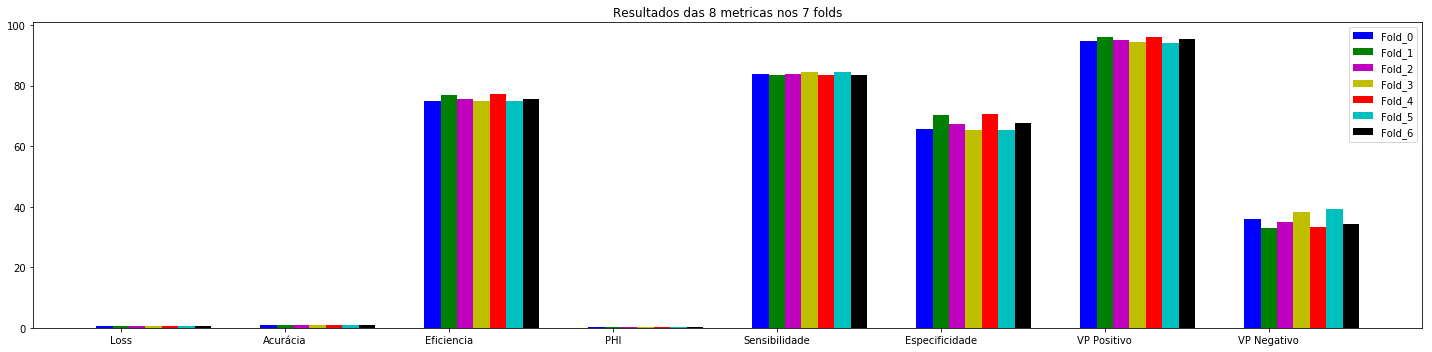

In [61]:

# data to plot
n_groups = 8
# means_frank = np.asarray([0, 1, 2, 4])
# means_guido = np.asarray([3, 5, 7, 9])

# create plot

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.1
opacity = 1

rects1 = plt.bar(index, fold0, bar_width,
alpha=opacity,
color='b',
label='Fold_0')

rects2 = plt.bar(index + bar_width, fold1, bar_width,
alpha=opacity,
color='g',
label='Fold_1')

rects3 = plt.bar(index + (bar_width*2), fold2, bar_width,
alpha=opacity,
color='m',
label='Fold_2')

rects4 = plt.bar(index + (bar_width*3), fold3, bar_width,
alpha=opacity,
color='y',
label='Fold_3')

rects5 = plt.bar(index + (bar_width*4), fold4, bar_width,
alpha=opacity,
color='r',
label='Fold_4')

rects6 = plt.bar(index + (bar_width*5), fold5, bar_width,
alpha=opacity,
color='c',
label='Fold_5')

rects7 = plt.bar(index + (bar_width*6), fold6, bar_width,
alpha=opacity,
color='k',
label='Fold_6')


# plt.xlabel('Person')
# plt.ylabel('Scores')
plt.title('Resultados das 8 metricas nos 7 folds')
plt.xticks(index + bar_width, ('Loss', 'Acurácia', 'Eficiencia', 'PHI', 'Sensibilidade', 'Especificidade', 'VP Positivo', 'VP Negativo'))

plt.legend()
plt.rcParams['figure.figsize'] = [30, 25]
plt.tight_layout()
plt.show()



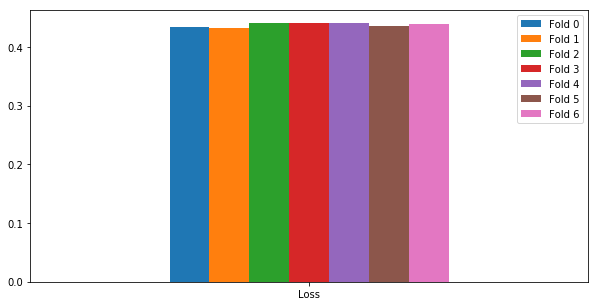

In [70]:
data = {'Fold 0':fold0[0],
        'Fold 1':fold1[0],
        'Fold 2':fold2[0],
        'Fold 3':fold3[0],
        'Fold 4':fold4[0],
        'Fold 5':fold5[0],
        'Fold 6':fold6[0]}

# Creates pandas DataFrame. 
dfResultados = pd.DataFrame(data, index =['Loss']) 

ax = dfResultados.plot.bar(rot=0)

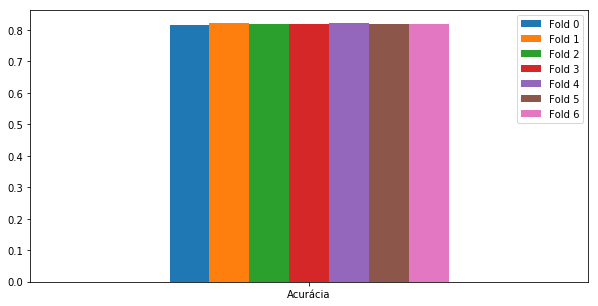

In [71]:
data = {'Fold 0':fold0[1],
        'Fold 1':fold1[1],
        'Fold 2':fold2[1],
        'Fold 3':fold3[1],
        'Fold 4':fold4[1],
        'Fold 5':fold5[1],
        'Fold 6':fold6[1]}

# Creates pandas DataFrame. 
dfResultados = pd.DataFrame(data, index =['Acurácia']) 

ax = dfResultados.plot.bar(rot=0)



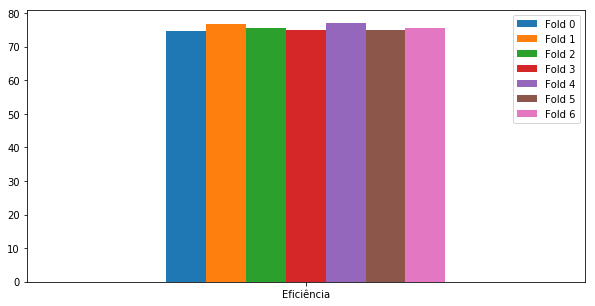

In [72]:
data = {'Fold 0':fold0[2],
        'Fold 1':fold1[2],
        'Fold 2':fold2[2],
        'Fold 3':fold3[2],
        'Fold 4':fold4[2],
        'Fold 5':fold5[2],
        'Fold 6':fold6[2]}

# Creates pandas DataFrame. 
dfResultados = pd.DataFrame(data, index =['Eficiência']) 

ax = dfResultados.plot.bar(rot=0)



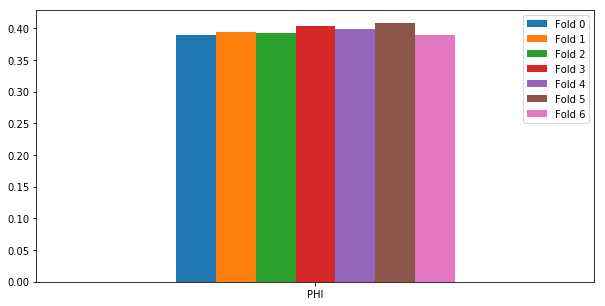

In [73]:
data = {'Fold 0':fold0[3],
        'Fold 1':fold1[3],
        'Fold 2':fold2[3],
        'Fold 3':fold3[3],
        'Fold 4':fold4[3],
        'Fold 5':fold5[3],
        'Fold 6':fold6[3]}

# Creates pandas DataFrame. 
dfResultados = pd.DataFrame(data, index =['PHI']) 

ax = dfResultados.plot.bar(rot=0)

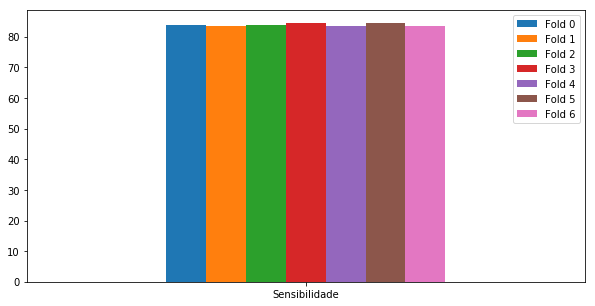

In [74]:
data = {'Fold 0':fold0[4],
        'Fold 1':fold1[4],
        'Fold 2':fold2[4],
        'Fold 3':fold3[4],
        'Fold 4':fold4[4],
        'Fold 5':fold5[4],
        'Fold 6':fold6[4]}

# Creates pandas DataFrame. 
dfResultados = pd.DataFrame(data, index =['Sensibilidade']) 

ax = dfResultados.plot.bar(rot=0)

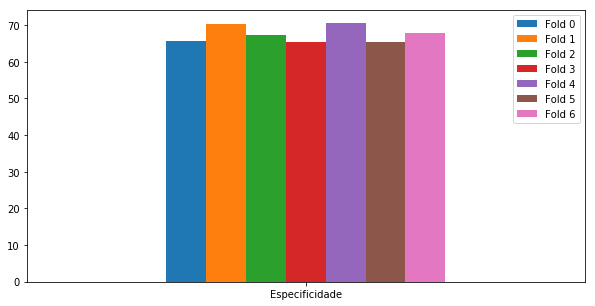

In [75]:

data = {'Fold 0':fold0[5],
        'Fold 1':fold1[5],
        'Fold 2':fold2[5],
        'Fold 3':fold3[5],
        'Fold 4':fold4[5],
        'Fold 5':fold5[5],
        'Fold 6':fold6[5]}

# Creates pandas DataFrame. 
dfResultados = pd.DataFrame(data, index =['Especificidade']) 

ax = dfResultados.plot.bar(rot=0)

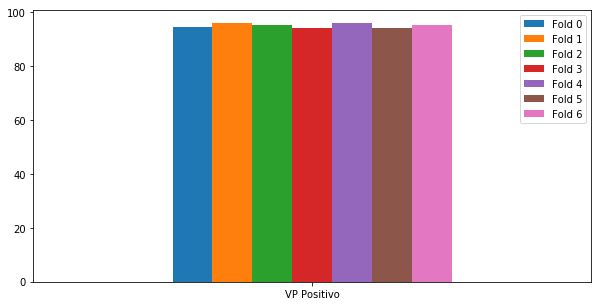

In [76]:

data = {'Fold 0':fold0[6],
        'Fold 1':fold1[6],
        'Fold 2':fold2[6],
        'Fold 3':fold3[6],
        'Fold 4':fold4[6],
        'Fold 5':fold5[6],
        'Fold 6':fold6[6]}

# Creates pandas DataFrame. 
dfResultados = pd.DataFrame(data, index =['VP Positivo']) 

ax = dfResultados.plot.bar(rot=0)

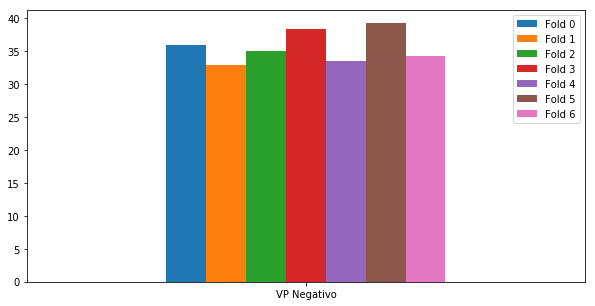

In [77]:
data = {'Fold 0':fold0[7],
        'Fold 1':fold1[7],
        'Fold 2':fold2[7],
        'Fold 3':fold3[7],
        'Fold 4':fold4[7],
        'Fold 5':fold5[7],
        'Fold 6':fold6[7]}

# Creates pandas DataFrame. 
dfResultados = pd.DataFrame(data, index =['VP Negativo']) 

ax = dfResultados.plot.bar(rot=0)

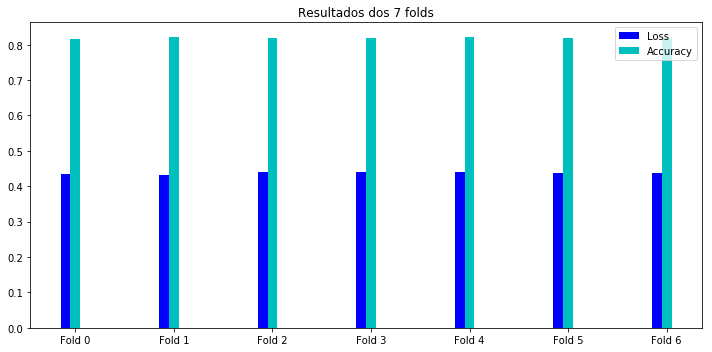

In [69]:

# data to plot
n_groups = 7
means_frank = np.asarray([0, 1, 2, 4])
means_guido = np.asarray([3, 5, 7, 9])

# create plot

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.1
opacity = 1

rects1 = plt.bar(index, test_loss, bar_width,
alpha=opacity,
color='b',
label='Loss')

rects2 = plt.bar(index + bar_width, test_accuracy, bar_width,
alpha=opacity,
color='c',
label='Accuracy')


# plt.xlabel('Person')
# plt.ylabel('Scores')
plt.title('Resultados dos 7 folds')
plt.xticks(index + bar_width, ('Fold 0', 'Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold 6'))
plt.legend()
plt.rcParams['figure.figsize'] = [10, 5]
plt.tight_layout()
plt.show()




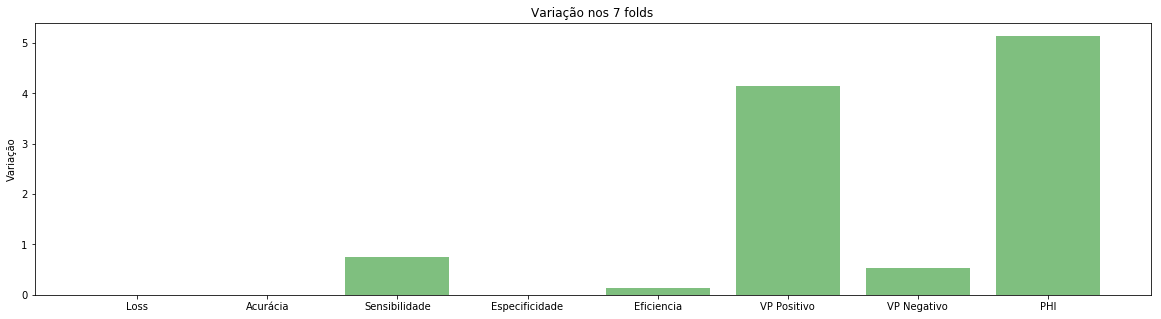

In [65]:
objects = ('Loss', 'Acurácia', 'Sensibilidade', 'Especificidade', 'Eficiencia', 'VP Positivo', 'VP Negativo', 'PHI')
y_pos = np.arange(len(objects))

totalVariation = np.asarray([test_loss.var(), test_accuracy.var(), test_eficiencia.var(), test_PHI.var(), test_sensibilidade.var(), test_especificidade.var(), test_valor_preditivo_positivo.var(), test_valor_preditivo_negativo.var()])

plt.bar(y_pos, totalVariation, align='center', alpha=0.5, color='g')
plt.xticks(y_pos, objects)
plt.ylabel('Variação')
plt.title('Variação nos 7 folds')
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()


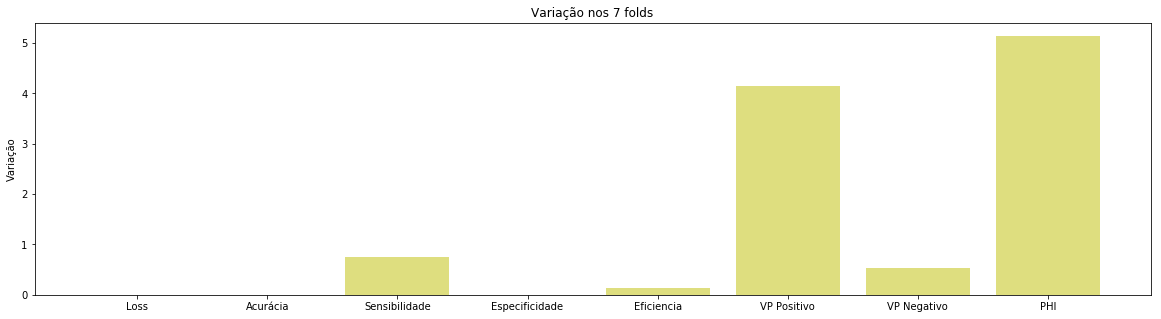

In [66]:
objects = ('Loss', 'Acurácia', 'Sensibilidade', 'Especificidade', 'Eficiencia', 'VP Positivo', 'VP Negativo', 'PHI')
y_pos = np.arange(len(objects))

totalVariation = np.asarray([test_loss.var(), test_accuracy.var(), test_eficiencia.var(), test_PHI.var(), test_sensibilidade.var(), test_especificidade.var(), test_valor_preditivo_positivo.var(), test_valor_preditivo_negativo.var()])

plt.bar(y_pos, totalVariation, align='center', alpha=0.5, color='y')
plt.xticks(y_pos, objects)
plt.ylabel('Variação')
plt.title('Variação nos 7 folds')
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()